# 2. Filtering diad files into categories
- This workbook shows how to filter cosmic rays and filter diad files into 3 categories, to allow easier fitting
- This data is from Devitre et al. (2021), collected from acqusitions on a high pressure optical cell on the Cornell WITec Alpha300R. 

In [1]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import os

C:\Users\charl\AppData\Local\Temp\ipykernel_8280\4289795608.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Downloading DiadFit locally
- The easiest way to install diad fit is by removing the #. It will install from PyPI
- You only need to do this once on each computer, or run in order to grab an updated version. 

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [2]:
import DiadFit as pf
pf.__version__

'0.0.58'

## Get the folder to your files
- If this notebook is in the same folder as your files, you can use os. to get the file name. Else paste in the file name as DayFolder='C:/Penny' or whatever you use on your computer. 
- In this case, Spectra files are stored in one subfolder called 'Spectra', Metadata files in another subfolder called 'MetaData'

In [3]:
MasterFolder=r"C:\Users\charl\Documents\Instruments and calibrations"
DayFolder=MasterFolder + "/UCB_5-10-23"

if not os.path.exists(MasterFolder + '\OUTPUT'):
    os.mkdir(MasterFolder +'\OUTPUT')
if not os.path.exists(MasterFolder + '\OUTPUT'+'\Pickles'):
    os.mkdir(MasterFolder + '\OUTPUT'+'\Pickles')

if not os.path.exists(DayFolder + '\GROUPS'):
    os.mkdir(DayFolder +'\GROUPS')

if not os.path.exists(DayFolder + '\FITOUT'):
    os.mkdir(DayFolder +'\FITOUT')


meta_path=DayFolder +  '\METADATA'
spectra_path=DayFolder + '\SPECTRA'

output_path=MasterFolder +"\OUTPUT"
fitout_path=DayFolder+'\FITOUT'
group_path=DayFolder+'\GROUPS'

filetype='headless_txt'

## This function finds all files in your path with the specified file format
- Specify information about your file formats here, as well as any text in filenames that you dont want to fit. 

In [4]:
filetype='headless_txt' # Specifies raman file format, here a text file with no header
file_ext='.txt' # File extension, a txt file
prefix=False # File doesn't have a 01, 02 prefix, as WItec can add
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Spectrum','CRR'] # Exclude files with these strings in
Diad_Files=pf.get_files(path=spectra_path, file_ext=file_ext, 
            exclude_str=exclude_str)
print(Diad_Files)

['02 C1.txt', '03 C2.txt', '05 C3.txt', '06 C4.txt', '07 C5.txt', '10 C6.txt', '11 C7.txt', '12 C8.txt', '14 C9.txt', '15 C10.txt', '17 C11.txt', '19 C12.txt', '21 C13.txt', '23 C14.txt', '25 C15.txt', '27 C16.txt', '29 C17.txt', '31 C18.txt', '33 C19.txt', '35 C20.txt', '37 C21.txt', '39 C22.txt']


## Find approximate peak positions
- Tweak Scipy parameters to find the diad peaks
- Tweak these parameters to make sure Scipy 'find_peaks' gets your diad peaks for your instrument.
- Prominence: most useful parameter, required prominence of peaks
- height: Minimum height of peaks, not that useful with various background positions
- distance: Used to help with peaks that are very close to one another, smaller distance, remove peaks until keep set distance apart
- width: Minimum width of peaks

In [5]:
# Tweak parameters away from the default here
diad_id_config=pf.diad_id_config(prominence=12, width=1)
diad_id_config

diad_id_config(height=1, width=1, prominence=12, plot_figure=True, exclude_range1=None, exclude_range2=None, approx_diad2_pos=(1379, 1395), approx_diad1_pos=(1275, 1290), Diad2_window=(1349, 1425), Diad1_window=(1245, 1320), approx_diad2_pos_3peaks=(1379, 1395, 1362))

,filename,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,HB1_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
5,02 C1.txt,103.376291,1285.518822,1388.895112,1265.291232,1410.250123,1370.57039,4065.457884,7048.725976,274.990352,...,1189.633288,829.007897,4756.757871,949.79034,691.299988,692.249985,4.518922,1.020473,58.166936,108.497475


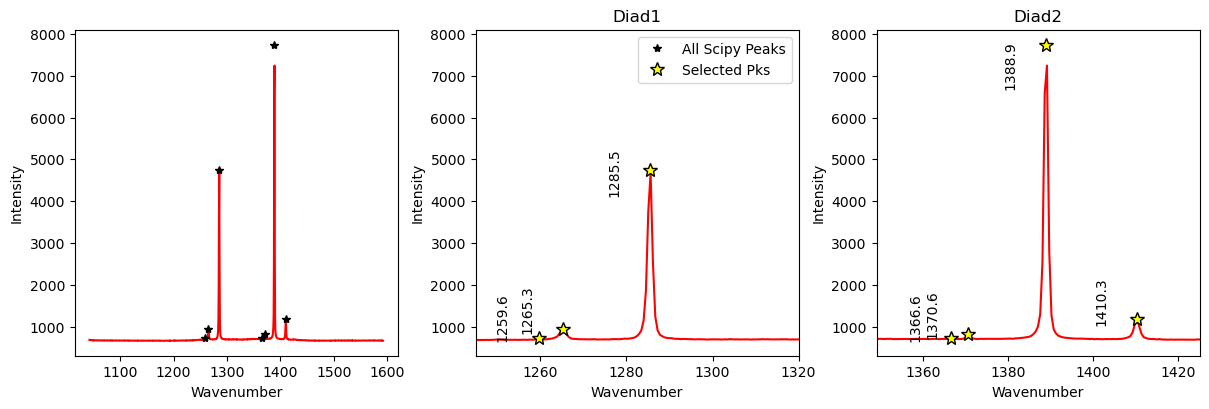

In [6]:
# Check it has found the peaks of interest. Here we are looking at the 1st file
df_peaks, Diad, fig=pf.identify_diad_peaks(
config=diad_id_config, 
path=spectra_path, filename=Diad_Files[0],
filetype=filetype, plot_figure=True)
## 'POC54.txt' Diad_Files[50] is problematic for HB IDing
df_peaks

### Now you have looked at a few files and are happy with these parameters, loop over all files to get approximate fit parameters for all your diad acquisitions

In [7]:
fit_params, data_y_all=pf.loop_approx_diad_fits(spectra_path=spectra_path, config=diad_id_config, 
                       Diad_Files=Diad_Files, filetype=filetype, plot_figure=False)
fit_params.head()

100%|██████████| 22/22 [00:00<00:00, 32.48it/s]


,filename,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,HB1_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,02 C1.txt,103.376291,1285.518822,1388.895112,1265.291232,1410.250123,1370.570390,4065.457884,7048.725976,274.990352,...,1189.633288,829.007897,4756.757871,949.790340,691.299988,692.249985,4.518922,1.020473,58.166936,108.497475
1,03 C2.txt,103.376291,1285.518822,1388.895112,1265.252735,1410.266622,1370.570390,4063.460760,7077.817438,274.737621,...,1187.142901,821.551512,4754.060766,949.137646,690.600006,691.749985,4.886889,1.020809,59.818310,111.138157
2,05 C3.txt,103.431287,1285.326335,1388.757622,1265.142743,1410.217125,1370.493395,4070.025254,7415.514647,289.549254,...,1199.915358,845.585252,4762.525254,964.799254,692.500000,693.812500,4.215604,1.029465,66.897640,120.612531
3,06 C4.txt,103.431287,1285.315336,1388.746622,1265.153742,1410.206126,1370.509894,4091.386271,7466.372715,278.902284,...,1204.432448,841.379448,4784.136271,954.152284,692.750000,694.000000,4.370647,1.025687,57.003529,107.646153
4,07 C5.txt,103.447786,1285.287838,1388.735623,1265.054749,1410.178628,1370.531893,4074.832174,7488.764399,286.174781,...,1190.280520,846.745314,4767.582174,961.674781,692.750000,694.062500,4.064878,1.030478,62.225695,111.362829


## Filter cosmic rays
### Pick a spectrum to tweak first

02 C1.txt


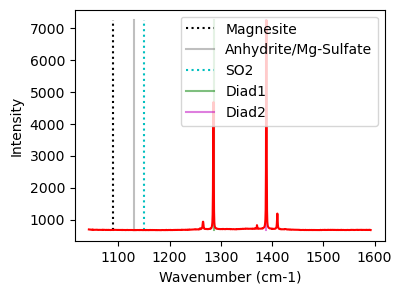

In [8]:
Diad_files=fit_params['filename']
i=0
filename_select=Diad_files.iloc[i] 
print(Diad_Files[i])
plot1=pf.plot_diad(path=spectra_path, filename=filename_select, filetype=filetype)

### Pick your other parameters
- NOTE that you can also change the number of neighbors considered in the intensity factor (n),but n=1 is often the best. dynfact is the intensity factor cutoff above which pixels are considered outliers in the first pass (y axis on the first plot on the leftmost). dynfact_2 is the same, but for the second pass. The filter automatically disregards pixels that are known to be of interest (here diads, hbs and c13). 


In [9]:
# This extract the peaks for the diads, HBs and C13 from fit_params, essential to the CRR process.
diad_peaks=fit_params[['Diad1_pos','Diad2_pos','HB1_pos','HB2_pos','C13_pos']]

#Pick your settings
plot_rays='all'#whether to plot the results, options are 'all' or 'rays_only'
export_cleanspec=True #whether to export the spectra with the cosmic ray pixels removed
save_fig='all' #whether to save the figures, options are 'all' or 'rays_only'
dynfact=0.0005 #dynamic intensity factor for the first pass (y axis on the leftmost plots)
dynfact_2=0.0005#dynamic intensity factor for the second pass
n=1 # number of neighboring pixels being compared, typically 1 is ideal.

exclude_ranges=None#[(1140,1160)] # List of tuples containing ranges to exclude from filtering (i.e., for secondary peaks)

### Run the filter on the selected spectrum

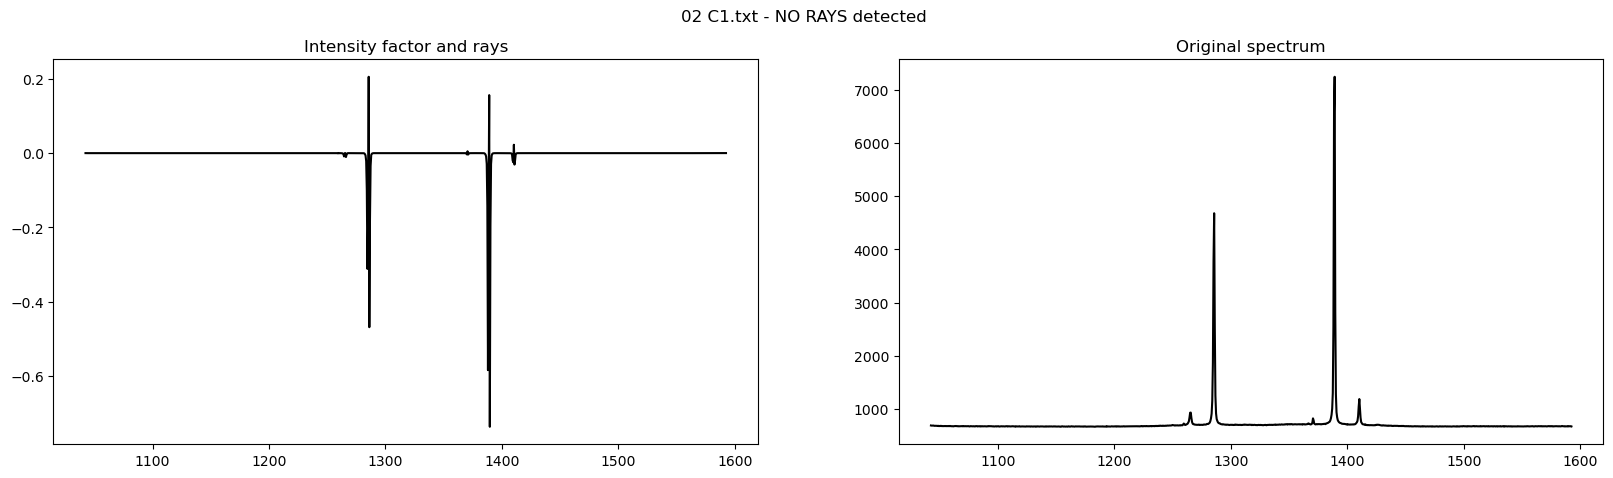

In [10]:
rays_found,spectrum=pf.cosmicray_filter.filter_singleray(path=spectra_path,Diad_files=Diad_files,i=i,diad_peaks=diad_peaks,
                                                         exclude_ranges=exclude_ranges,
                                                         plot_rays=plot_rays,
                                      export_cleanspec=export_cleanspec,save_fig=save_fig,dynfact=dynfact,dynfact_2=dynfact_2,n=n, filetype=filetype)

#rays_found is a dataframe containing the filename and whether cosmic rays were found. spectrum is the filtered spectrum in the form of a dataframe. 
#It contains nan values where the cosmic rays are. It is NOT for fitting.

### Now Loop over all other spectra
- the output of this is the data_y_all file, which contains plottable spectra and the new fit_params file with filtered spectra

In [11]:
fit_params

,filename,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,HB1_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,02 C1.txt,103.376291,1285.518822,1388.895112,1265.291232,1410.250123,1370.570390,4065.457884,7048.725976,274.990352,...,1189.633288,829.007897,4756.757871,949.790340,691.299988,692.249985,4.518922,1.020473,58.166936,108.497475
1,03 C2.txt,103.376291,1285.518822,1388.895112,1265.252735,1410.266622,1370.570390,4063.460760,7077.817438,274.737621,...,1187.142901,821.551512,4754.060766,949.137646,690.600006,691.749985,4.886889,1.020809,59.818310,111.138157
2,05 C3.txt,103.431287,1285.326335,1388.757622,1265.142743,1410.217125,1370.493395,4070.025254,7415.514647,289.549254,...,1199.915358,845.585252,4762.525254,964.799254,692.500000,693.812500,4.215604,1.029465,66.897640,120.612531
3,06 C4.txt,103.431287,1285.315336,1388.746622,1265.153742,1410.206126,1370.509894,4091.386271,7466.372715,278.902284,...,1204.432448,841.379448,4784.136271,954.152284,692.750000,694.000000,4.370647,1.025687,57.003529,107.646153
4,07 C5.txt,103.447786,1285.287838,1388.735623,1265.054749,1410.178628,1370.531893,4074.832174,7488.764399,286.174781,...,1190.280520,846.745314,4767.582174,961.674781,692.750000,694.062500,4.064878,1.030478,62.225695,111.362829
5,10 C6.txt,103.530280,1285.056854,1388.587134,1264.801766,1410.063136,1370.449398,4716.724451,9082.799281,304.901690,...,1267.375697,901.013051,5416.724451,983.151690,700.000000,701.687500,3.632268,1.044263,59.812260,114.906130
6,11 C7.txt,103.530280,1285.051354,1388.581634,1264.906259,1410.046637,1370.460398,4795.328604,9269.922018,329.198119,...,1264.332379,893.434669,5494.328604,1006.698119,699.000000,701.187500,3.729287,1.044144,62.592328,110.745965
7,12 C8.txt,103.530280,1285.045854,1388.576134,1264.955756,1409.980642,1370.454898,4806.978093,9377.731274,327.951263,...,1267.531866,900.929703,5505.978093,1005.451263,699.000000,701.375000,3.581245,1.045141,59.702613,106.548932
8,14 C9.txt,103.541279,1285.029356,1388.570635,1264.895260,1410.013639,1370.410901,4583.982201,8935.876347,304.551352,...,1243.663504,893.019008,5283.982201,983.051352,700.000000,701.750000,3.667551,1.045640,64.676640,119.278762
9,15 C10.txt,103.563277,1284.990858,1388.554136,1264.867762,1410.002640,1370.427400,4957.569341,9794.887541,332.435056,...,1300.874902,904.148663,5658.069341,1009.935056,700.500000,702.875000,3.930306,1.057072,76.566701,142.482169


 91%|█████████ | 20/22 [00:05<00:00,  3.67it/s]c:\users\charl\documents\python dev\diadfit\src\DiadFit\cosmicray_filter.py:367: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0,ax1) = plt.subplots(1,2,figsize=figsize)
100%|██████████| 22/22 [00:06<00:00,  3.53it/s]


,filename,rays_present,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,02 C1.txt,False,103.376291,1285.518822,1388.895112,1265.291232,1410.250123,1370.570390,4065.457884,7048.725976,...,1189.633288,829.007897,4756.757871,949.790340,691.299988,692.249985,4.518922,1.020473,58.166936,108.497475
1,03 C2_CRR_DiadFit.txt,True,103.376291,1285.518822,1388.895112,1265.252735,1410.266622,1370.570390,4063.460760,7077.817438,...,1187.142901,821.551512,4754.060766,949.137646,690.600006,691.749985,4.886889,1.020809,59.818310,111.138157
2,05 C3.txt,False,103.431287,1285.326335,1388.757622,1265.142743,1410.217125,1370.493395,4070.025254,7415.514647,...,1199.915358,845.585252,4762.525254,964.799254,692.500000,693.812500,4.215604,1.029465,66.897640,120.612531
3,06 C4.txt,False,103.431287,1285.315336,1388.746622,1265.153742,1410.206126,1370.509894,4091.386271,7466.372715,...,1204.432448,841.379448,4784.136271,954.152284,692.750000,694.000000,4.370647,1.025687,57.003529,107.646153
4,07 C5.txt,False,103.447786,1285.287838,1388.735623,1265.054749,1410.178628,1370.531893,4074.832174,7488.764399,...,1190.280520,846.745314,4767.582174,961.674781,692.750000,694.062500,4.064878,1.030478,62.225695,111.362829


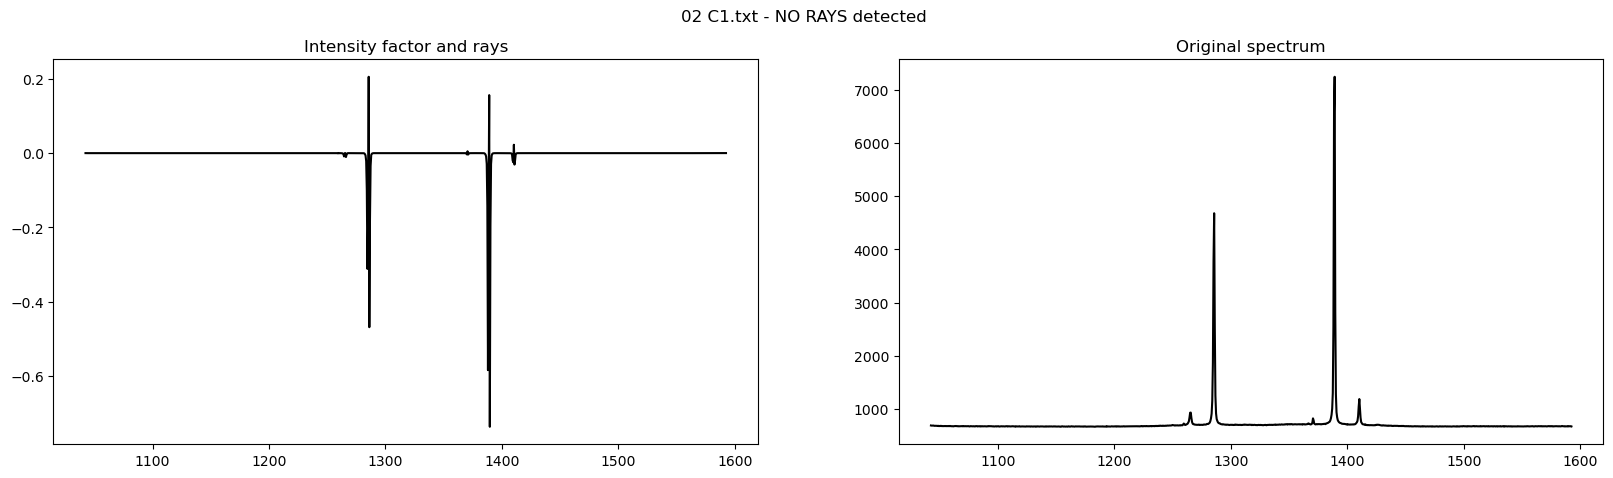

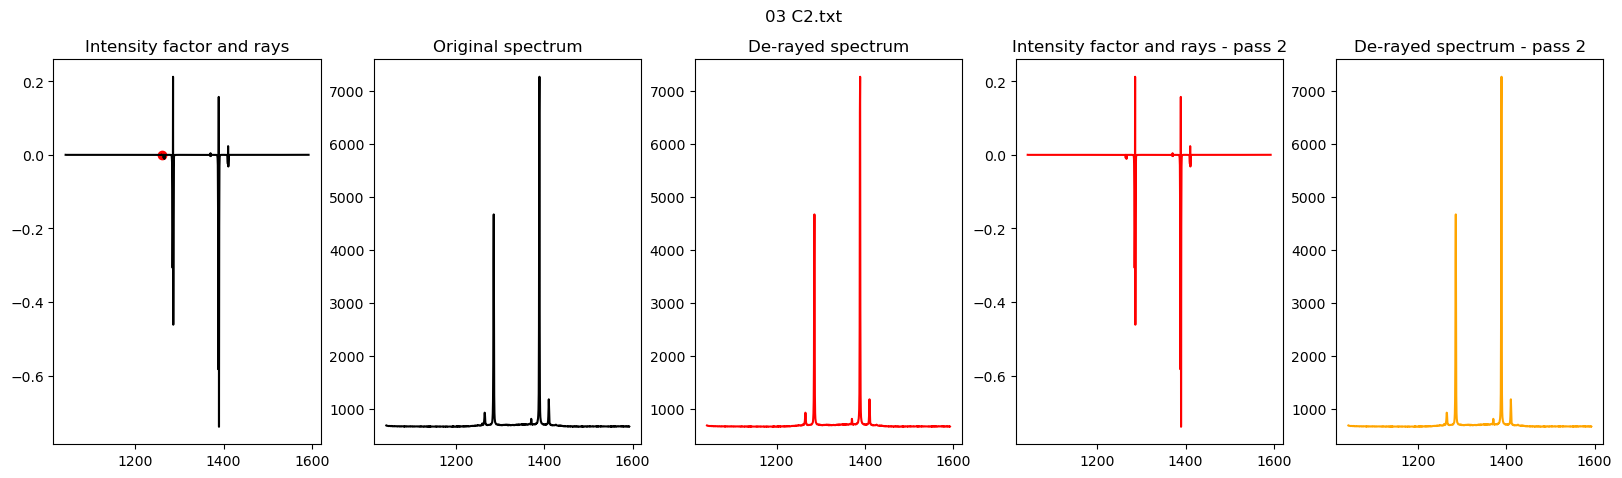

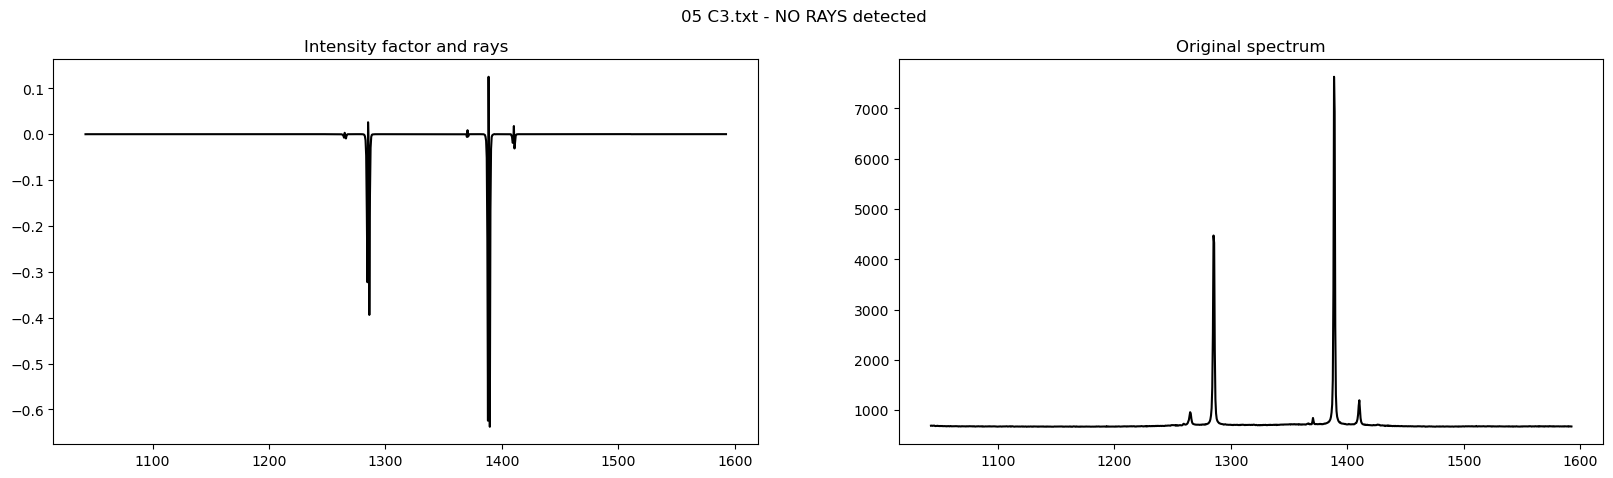

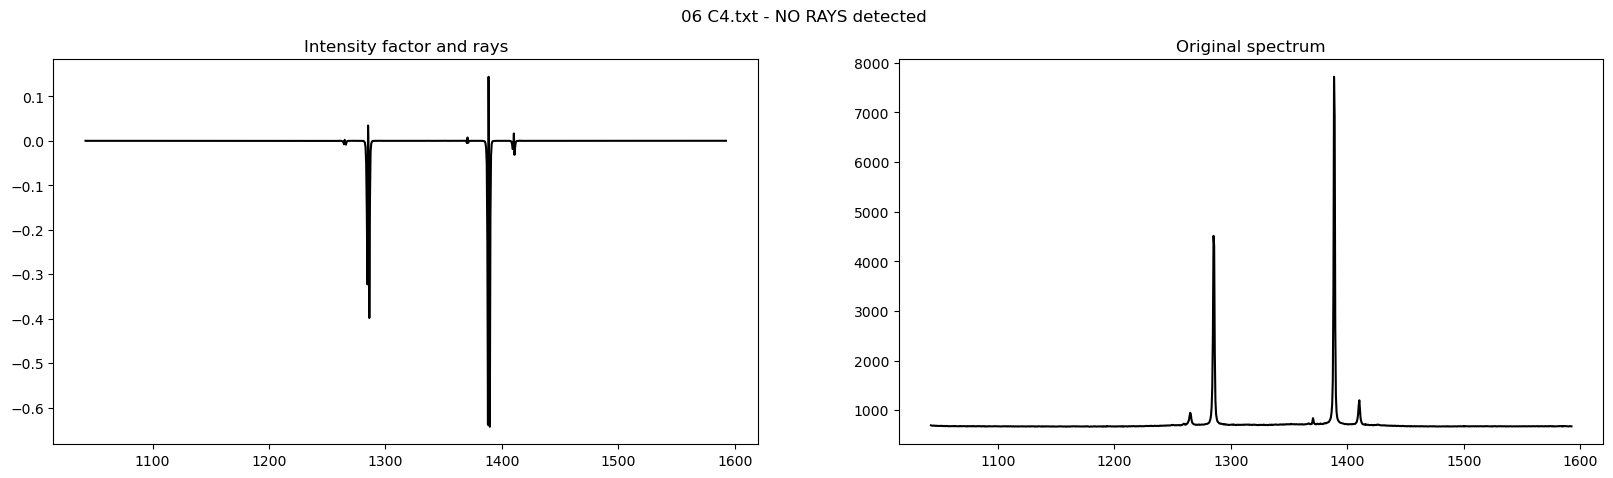

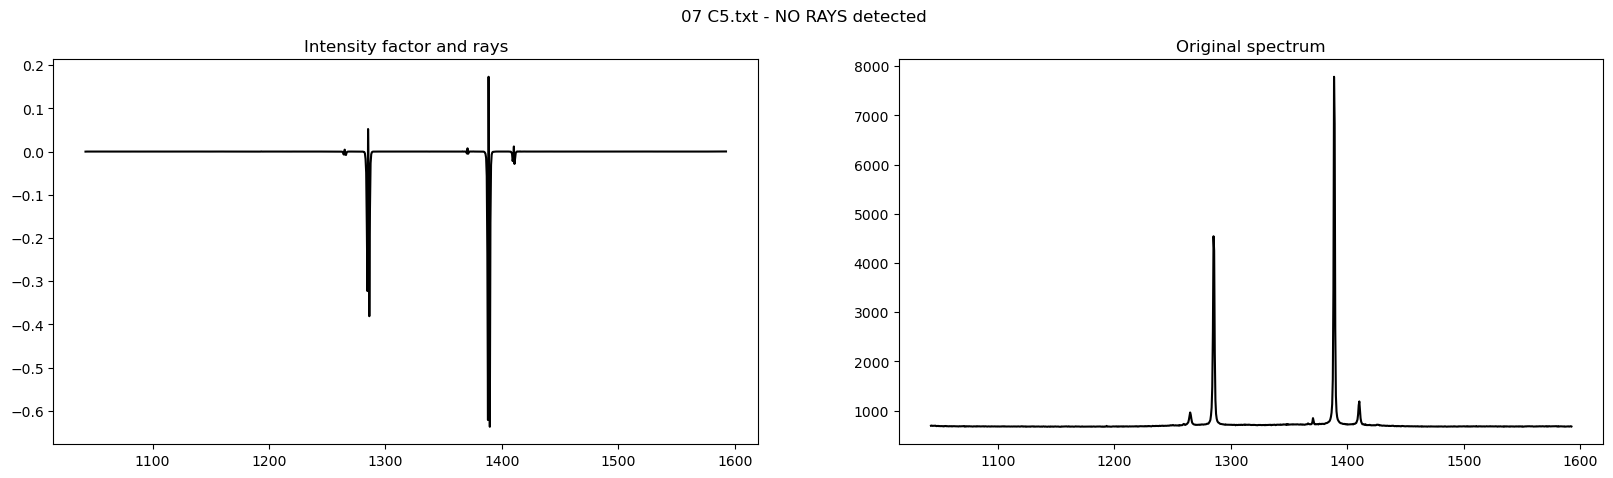

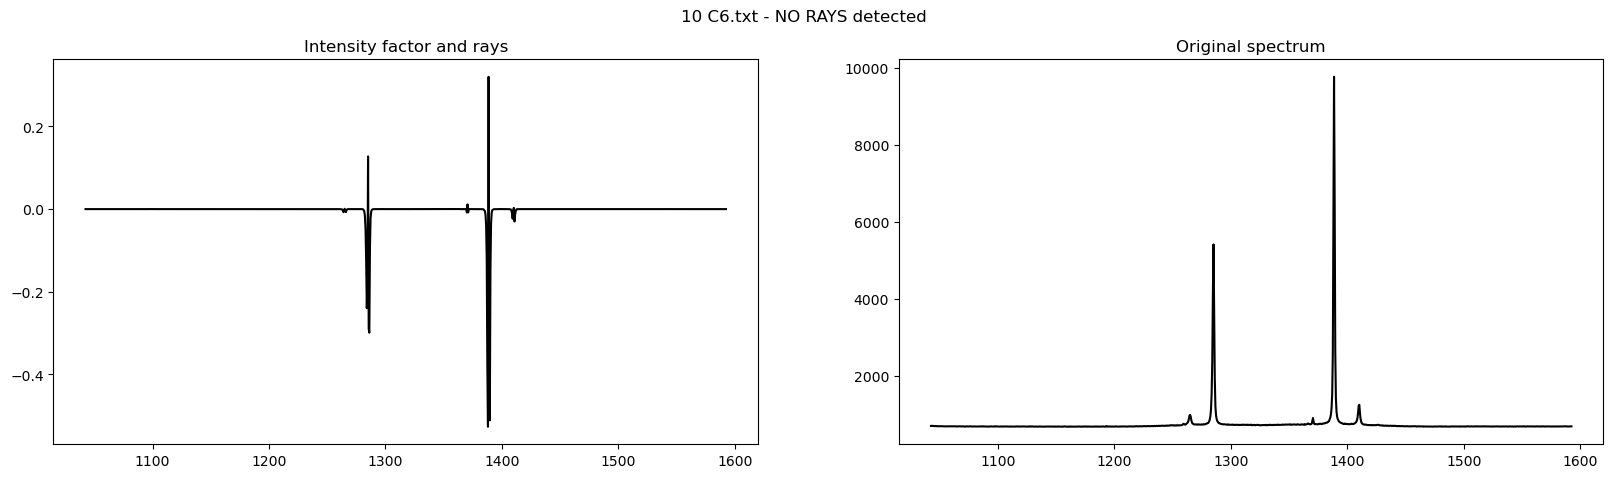

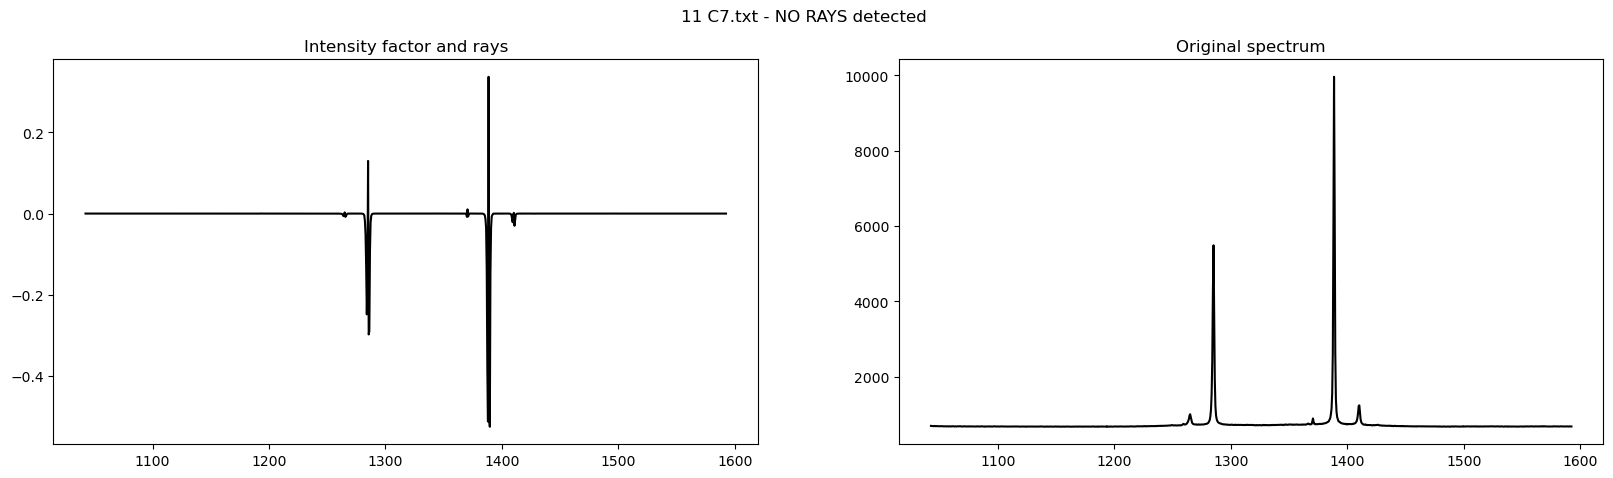

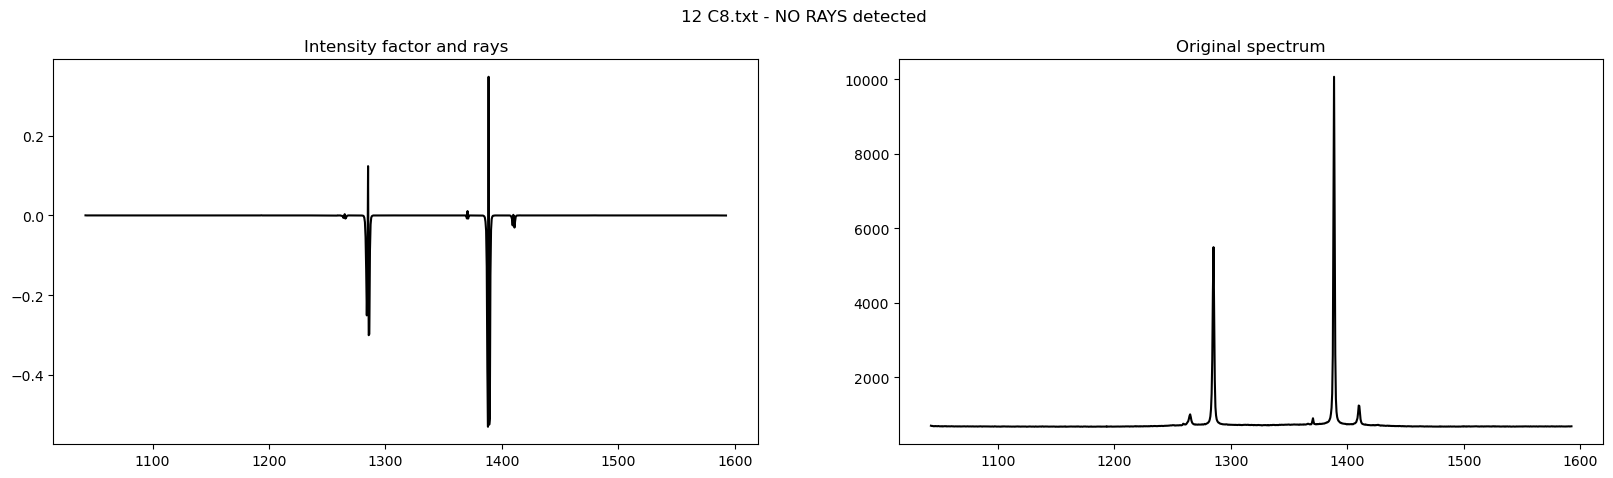

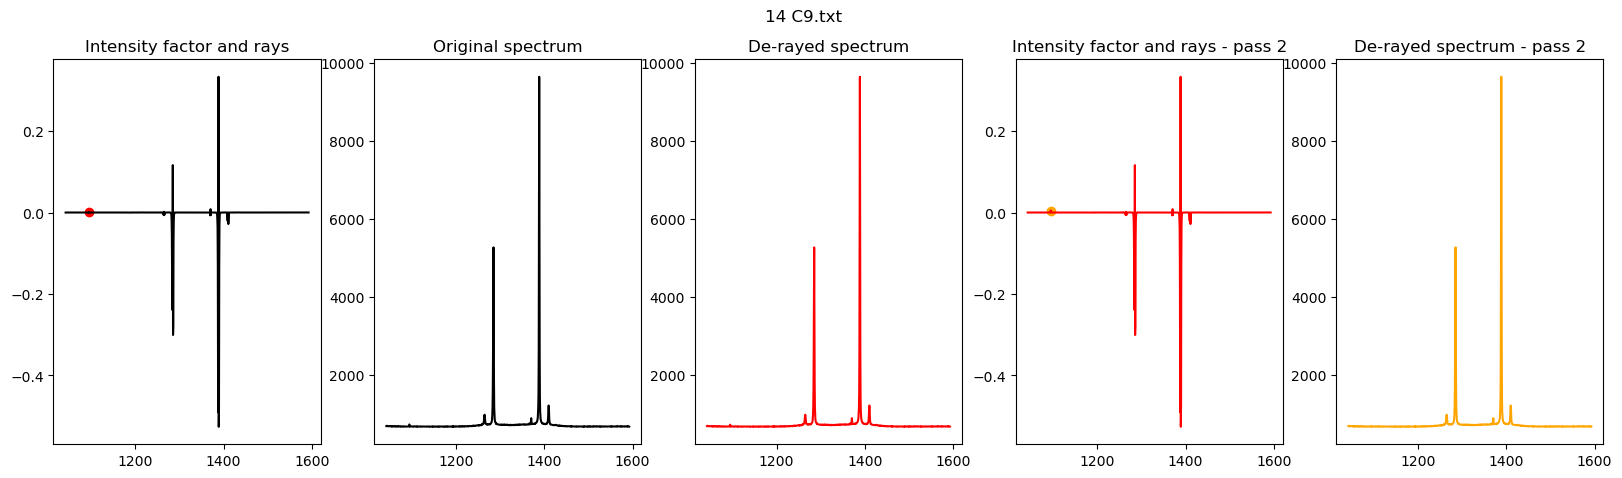

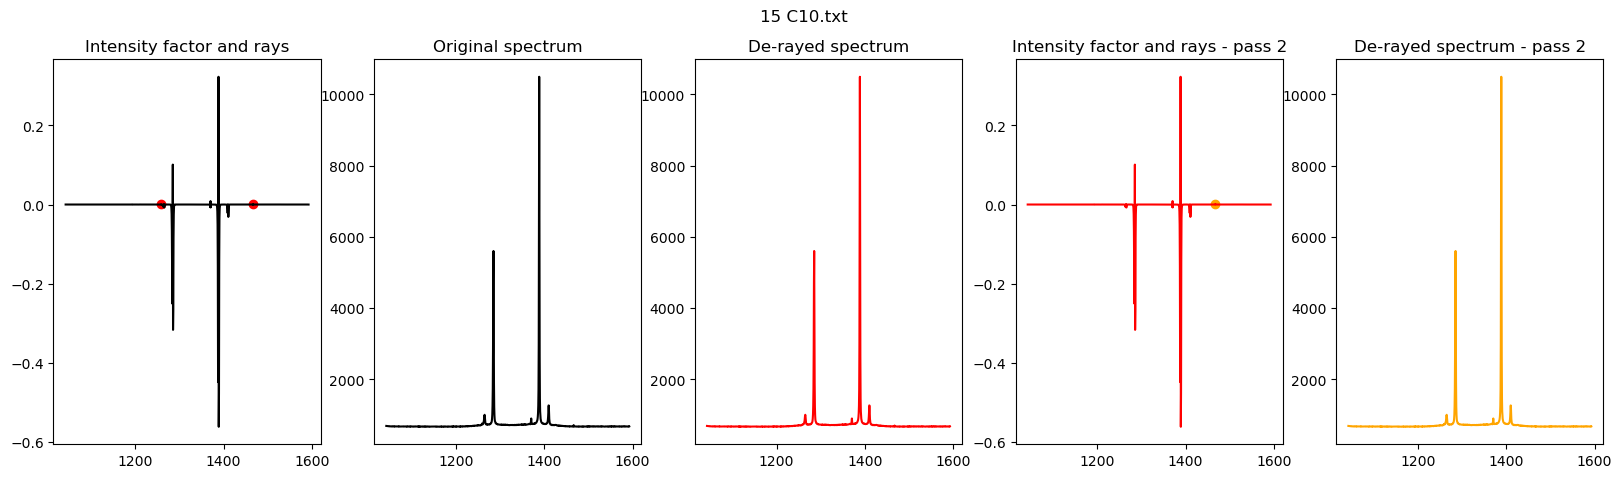

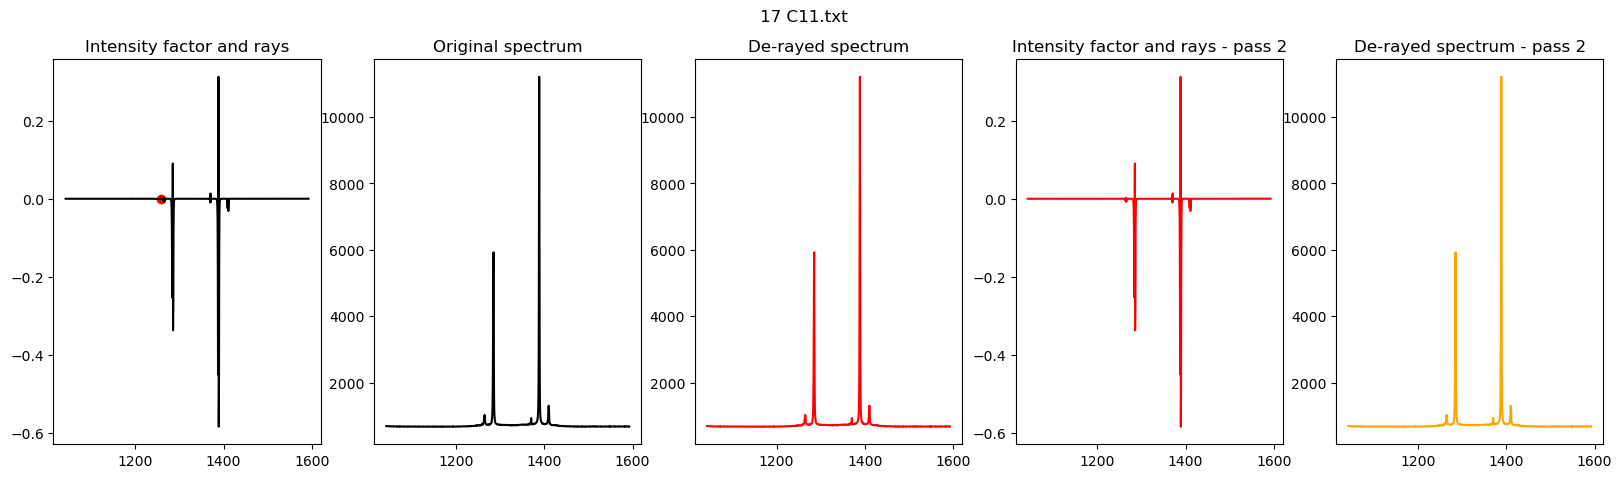

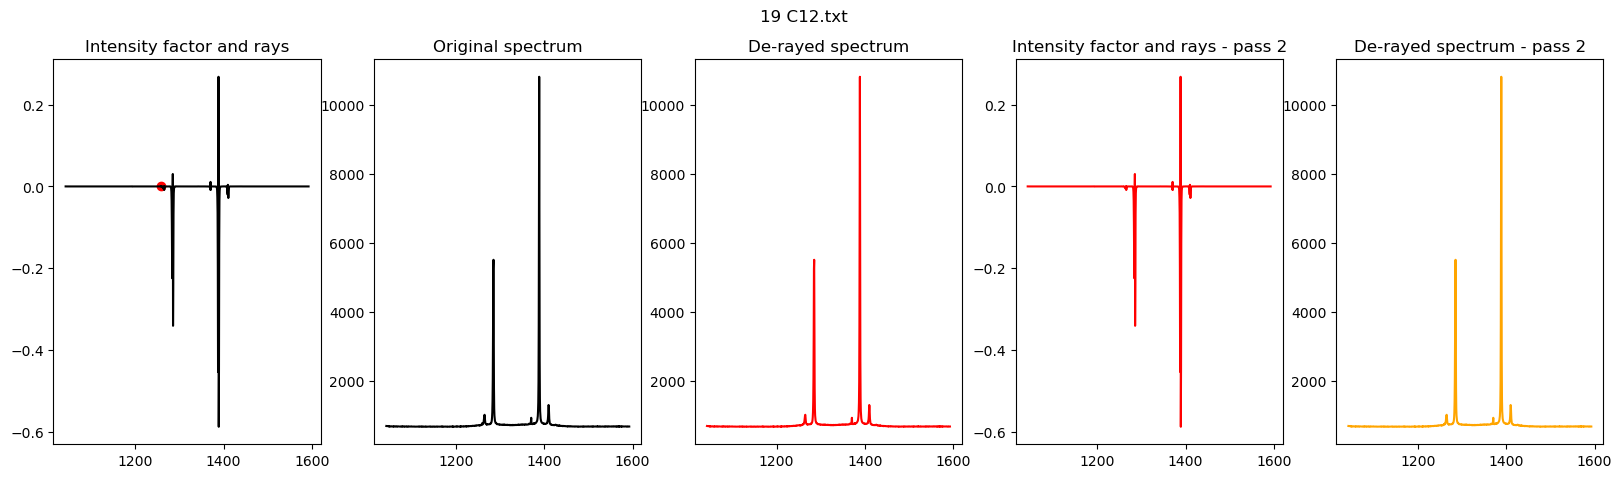

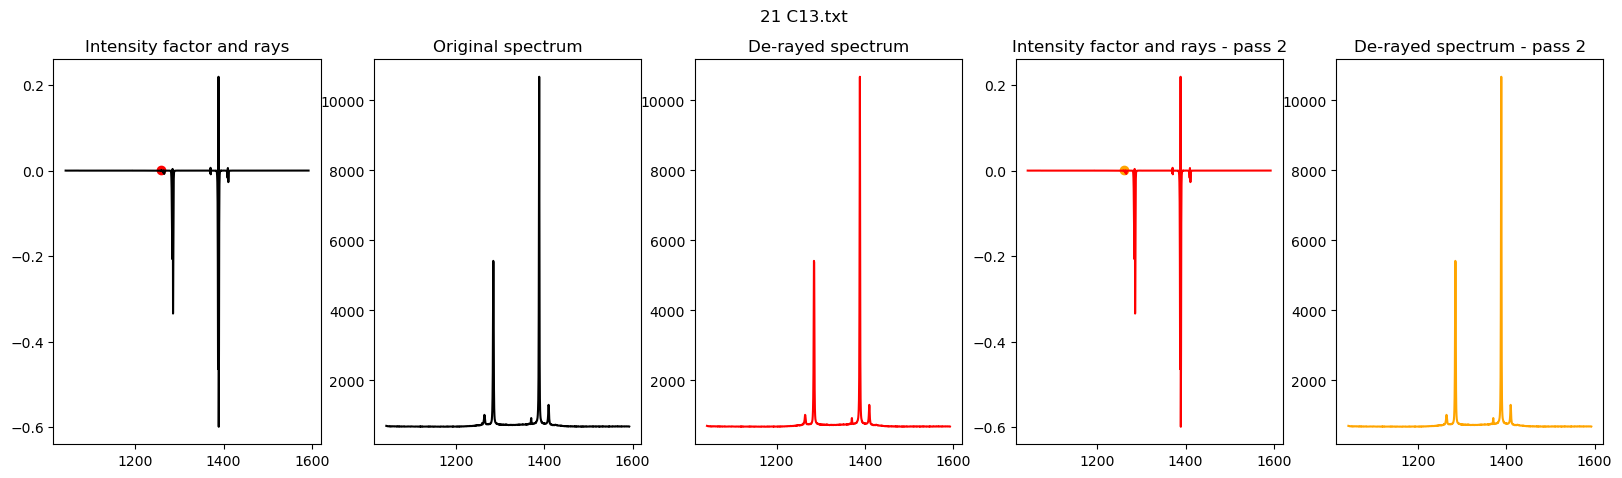

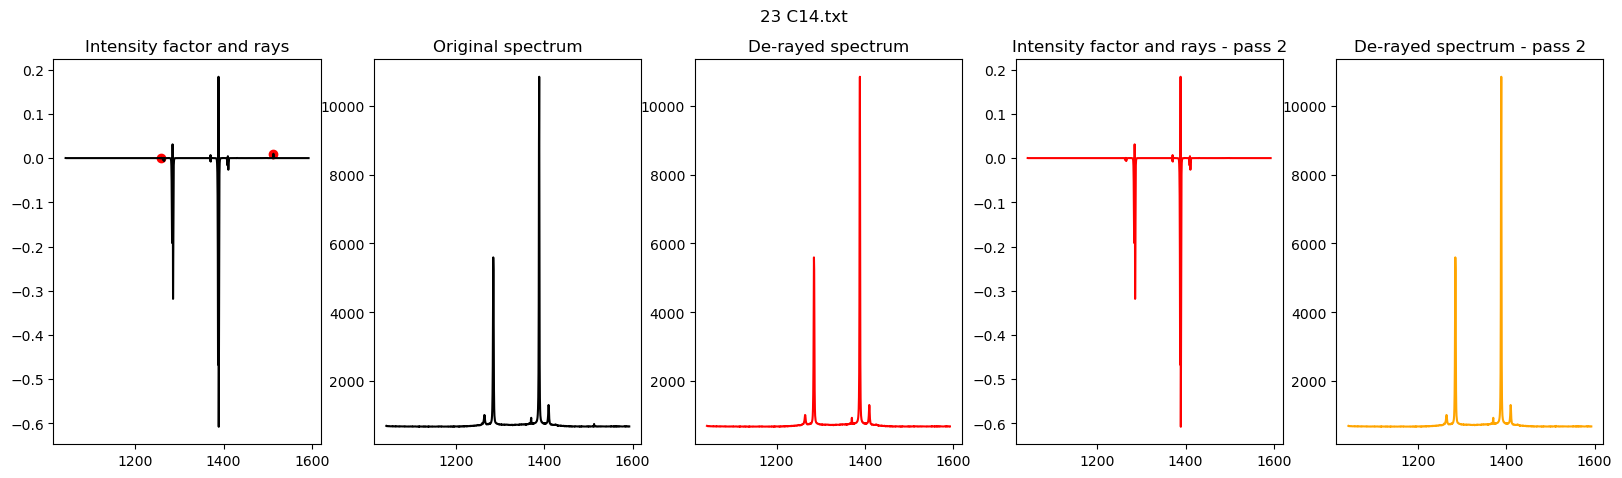

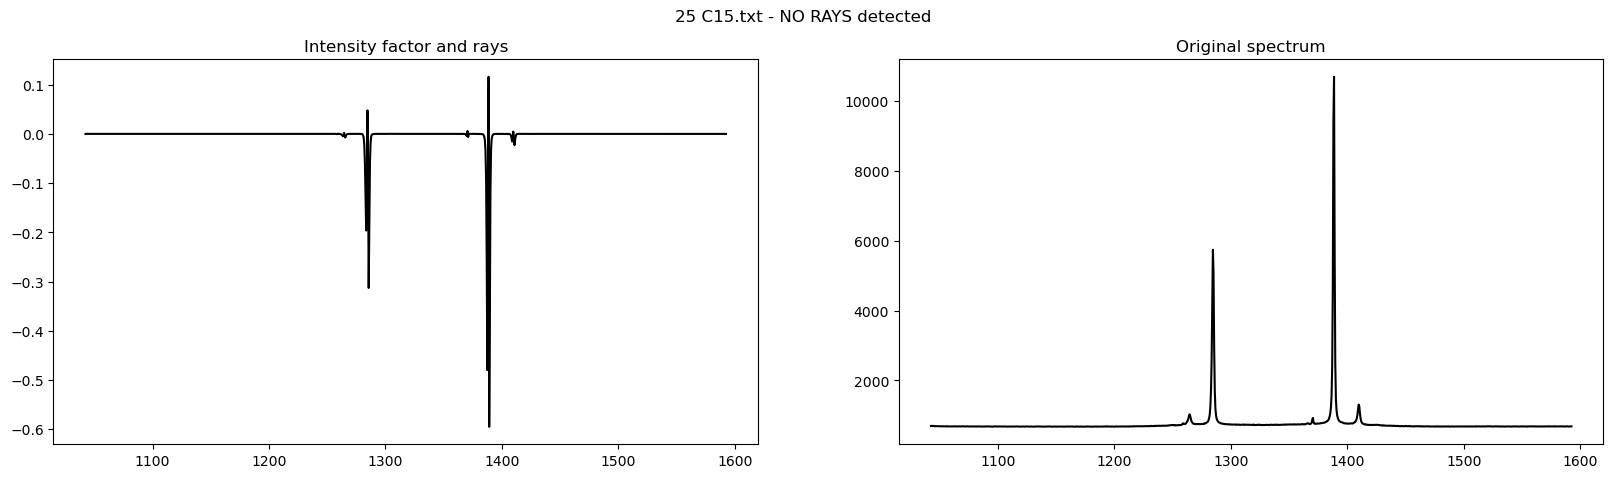

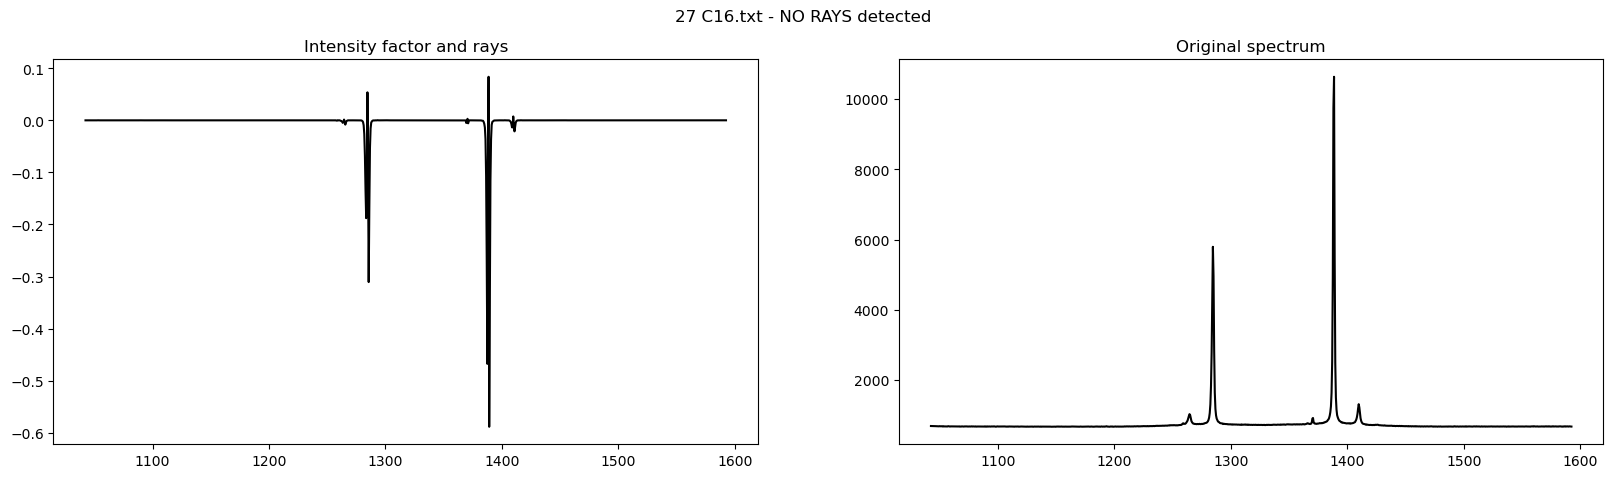

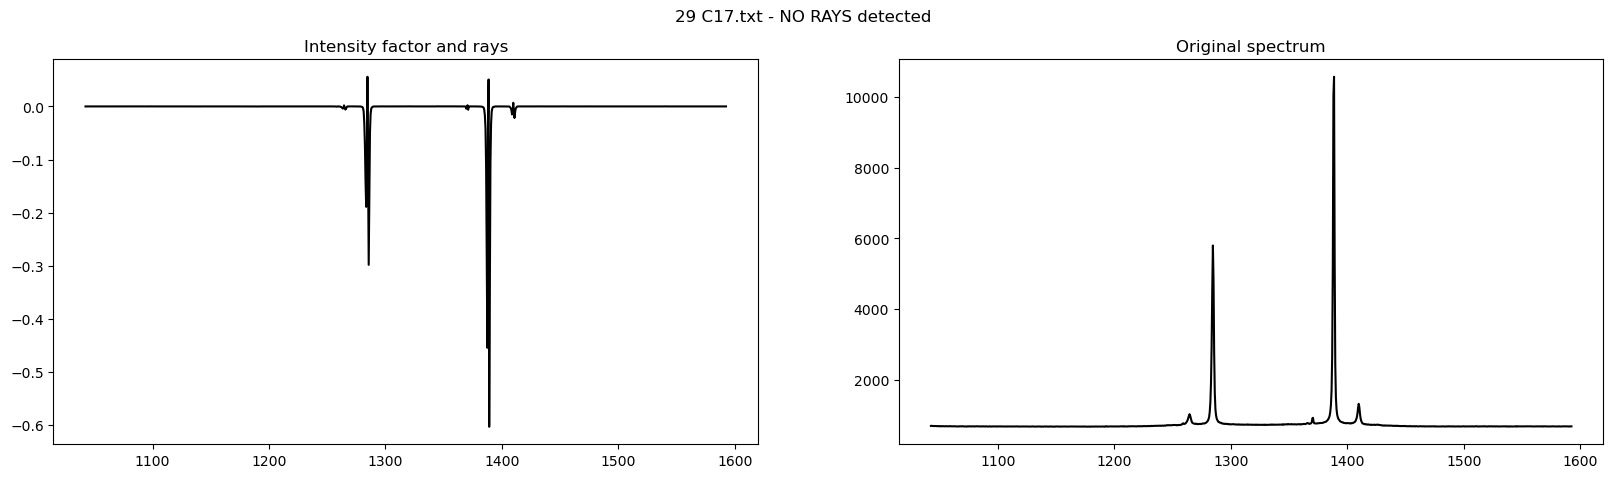

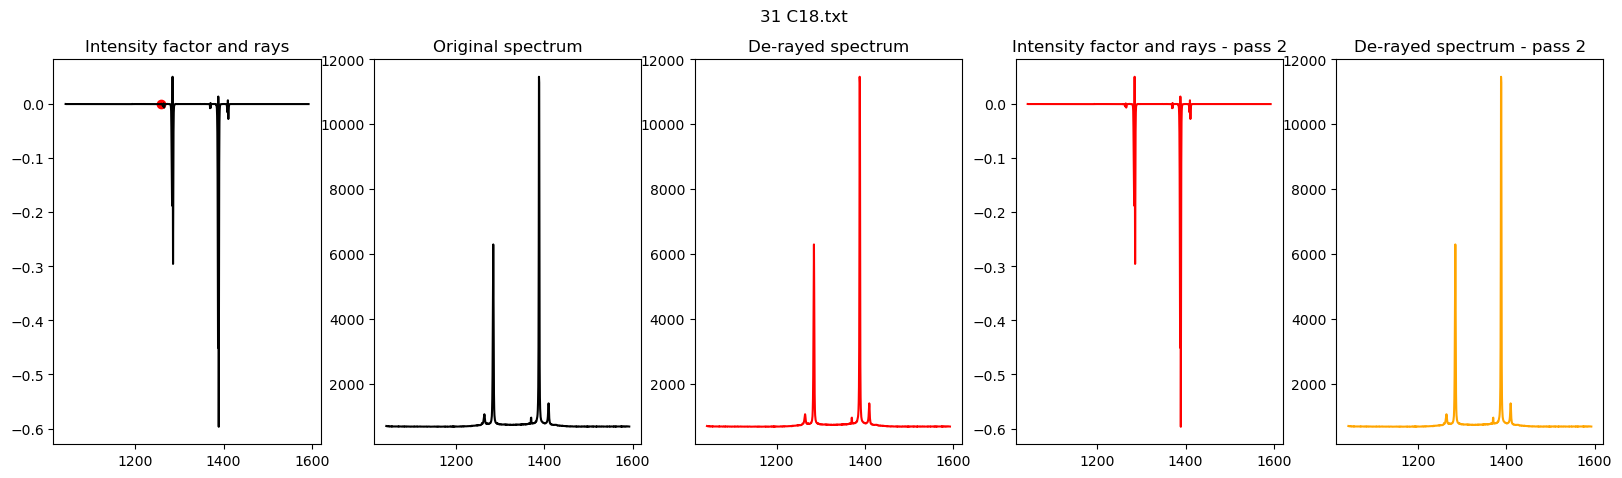

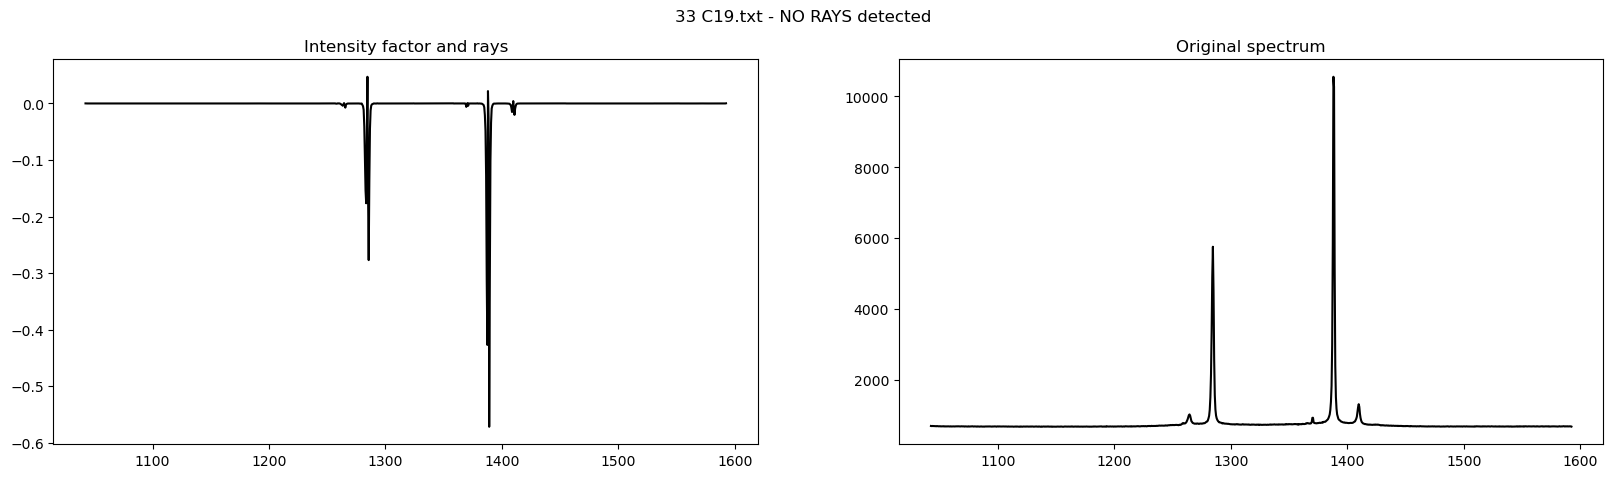

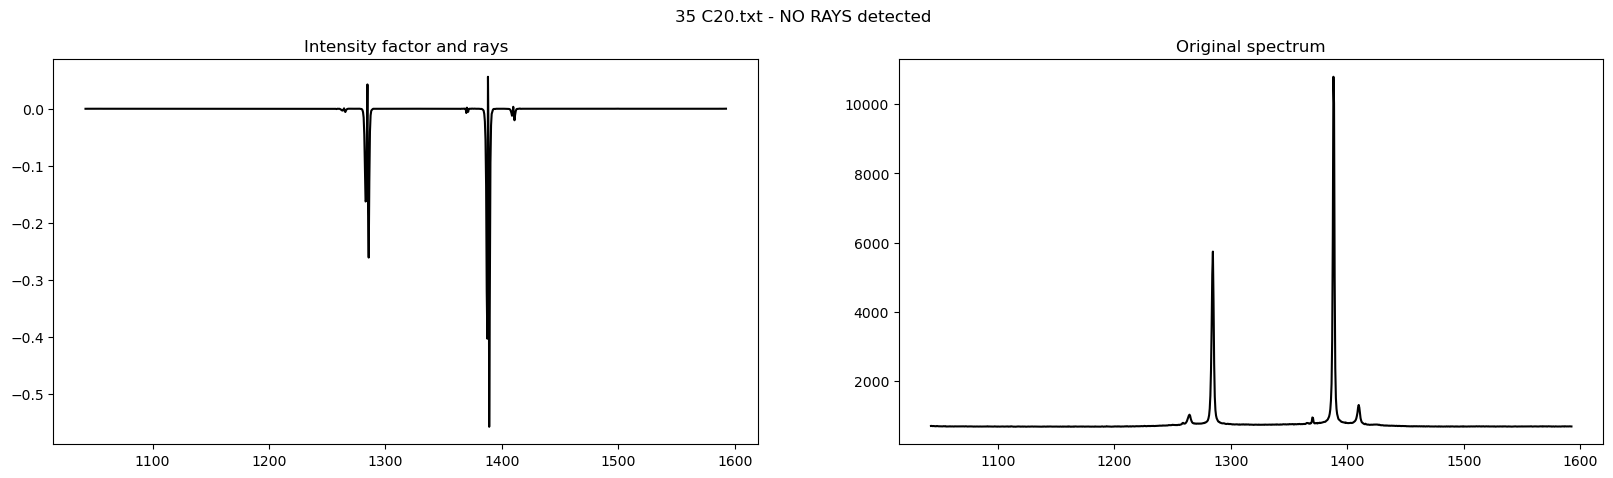

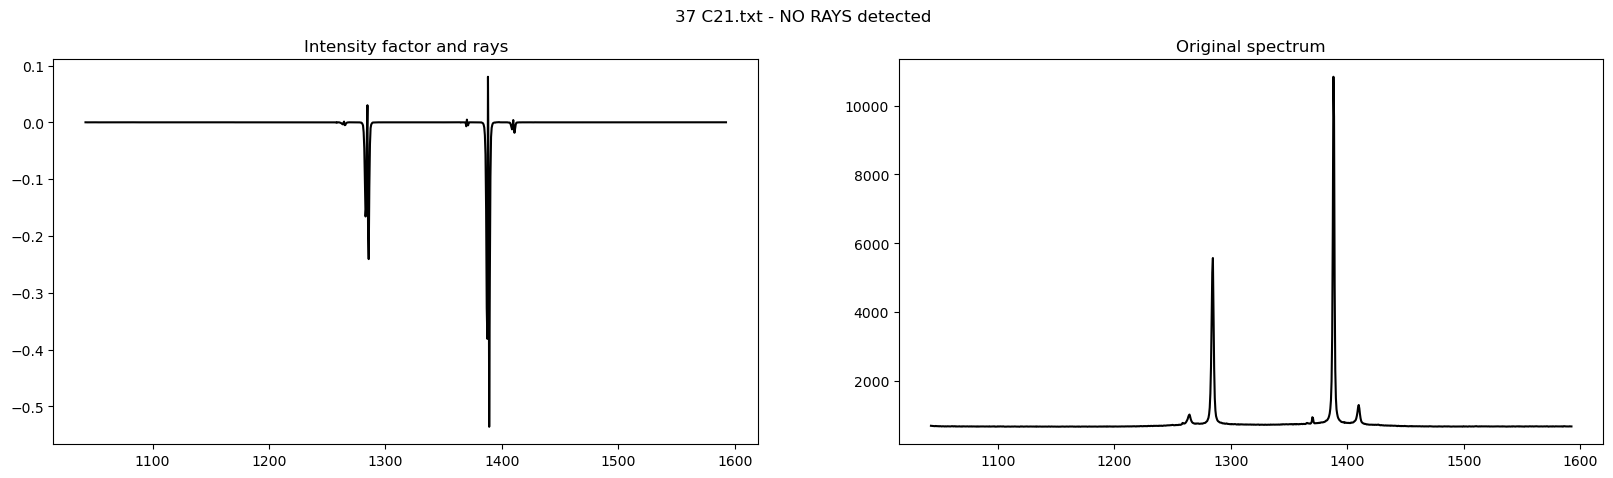

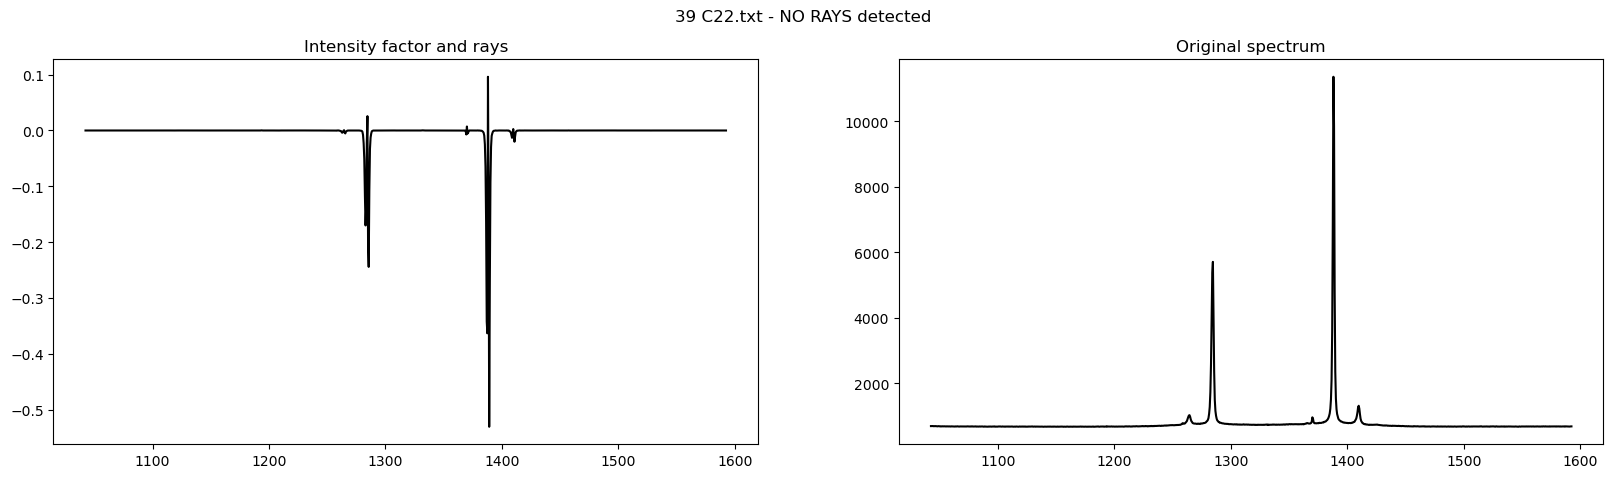

In [12]:
diad_peaks=fit_params[['Diad1_pos','Diad2_pos','HB1_pos','HB2_pos','C13_pos']]

data_y_all_crr,fit_params_crr=pf.cosmicray_filter.filter_raysinloop(Diad_files=Diad_files, spectra_path=spectra_path, 
                                                                    diad_peaks=diad_peaks,exclude_ranges=exclude_ranges,filetype=filetype,
                                                                    dynfact=dynfact,dynfact_2=dynfact_2,n=n,
                                      export_cleanspec=export_cleanspec,save_fig=save_fig,plot_rays=plot_rays,fit_params=fit_params)

### Plot peak parameters 
- This will help you inspect clear cut offs you can use to split your diads into groups for fitting
- You can enter different x and y coordinates from the dataframe headings above

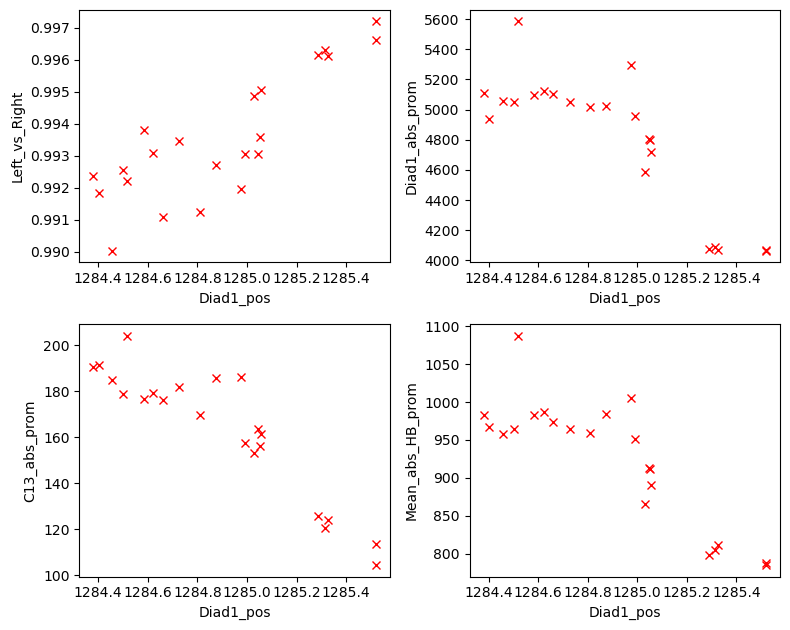

In [13]:
fig=pf.plot_peak_params(fit_params=fit_params_crr, 
                     x_param='Diad1_pos',  y1_param='Left_vs_Right',
                    y2_param='Diad1_abs_prom', y3_param='C13_abs_prom',
                    y4_param='Mean_abs_HB_prom', fill_na=-1000)

### Filter out ones with really bad splitting or really low diad prominence
- Here, we only take files with splitting between 101-108 (you will need to tweak this for each instrument)
- We also only take files with a prominence of diad 1 >10
- None here got filtered out, but these can be helpful filters on other datasets

Keeping N=22
Discarding N=0


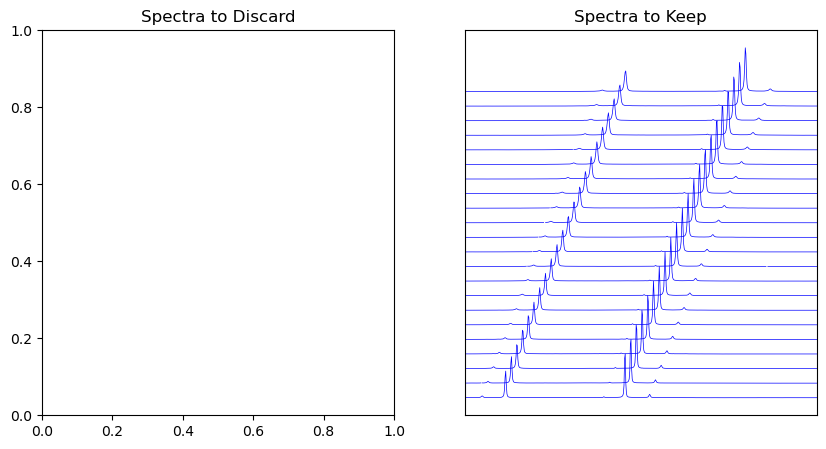

In [14]:
fit_params_filt, data_y_filt, fit_params_disc, data_y_disc=pf.filter_splitting_prominence(
fit_params=fit_params_crr, data_y_all=data_y_all_crr, x_cord=Diad[:, 0],
splitting_limits=[101, 108], lower_diad1_prom=10)

### Now apply filters to find the weakest diads (e.g. ones you wouldnt want to fit a hotband too)
- In this case, we find the best filters are the position of Diad1 (shifts way more than Diad2), 
and where HB2 had a prominence (e.g., not nan because it wasnt found) 
- We find it also helpful to apply a filter, e.g. weak is Diad1pos<1287 or HB2 prominence nan, and  the prominence of Diad1 is <300X the standard deviation of the diad region

Index(['filename', 'rays_present', 'approx_split', 'Diad1_pos', 'Diad2_pos',
       'HB1_pos', 'HB2_pos', 'C13_pos', 'Diad1_abs_prom', 'Diad2_abs_prom',
       'HB1_abs_prom', 'HB2_abs_prom', 'C13_abs_prom', 'Mean_abs_HB_prom',
       'Diad2_HB2_abs_prom_ratio', 'Diad1_HB1_abs_prom_ratio',
       'Diad1_rel_prom', 'Diad2_rel_prom', 'HB1_rel_prom', 'HB2_rel_prom',
       'C13_rel_prom', 'Diad1_HB1_Valley_prom', 'Mean_Diad_HB_Valley_prom',
       'Diad1_prom/std_betweendiads', 'Diad2_prom/std_betweendiads',
       'Av_Diad_prom/std_betweendiads', 'C13_prom/HB2_prom',
       'Av_Diad_HB_prom_ratio', 'Left_vs_Right', 'Diad2_height', 'HB2_height',
       'C13_height', 'Diad1_height', 'HB1_height', 'Diad1_Median_Bck',
       'Diad2_Median_Bck', 'C13_HB2_abs_prom_ratio', 'Diad2_HB2_Valley_prom',
       'HB1_prom/std_betweendiads', 'HB2_prom/std_betweendiads'],
      dtype='object')

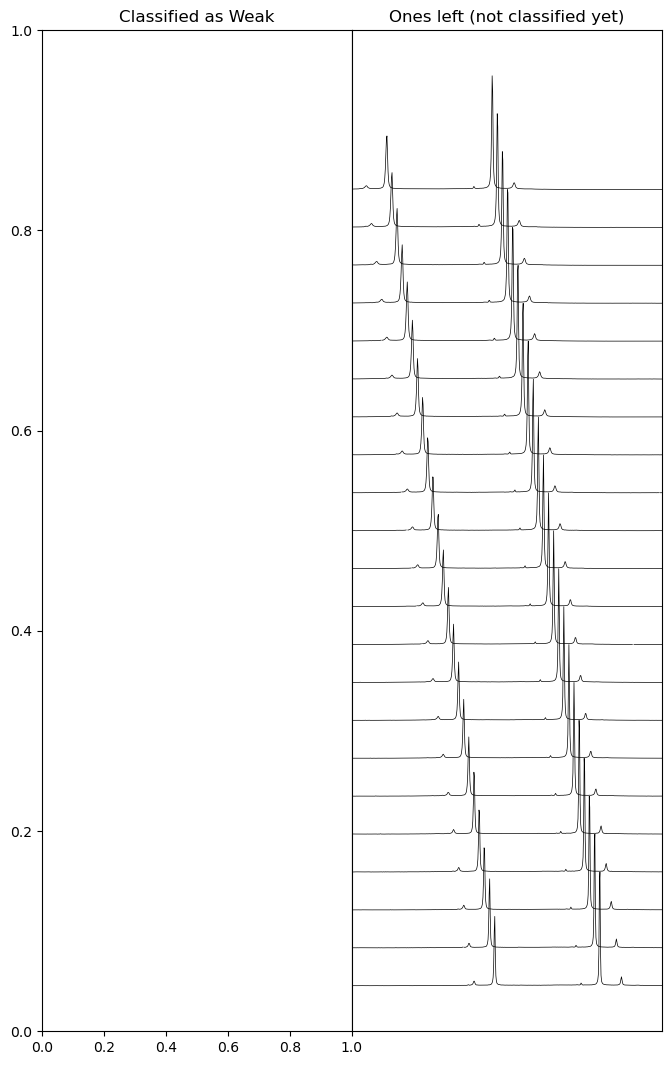

In [15]:
Filter1=(fit_params['C13_abs_prom']<10) # any C13 absolute prominence <10 is considered weak
Filter2=(fit_params['Left_vs_Right']>1.1) | (fit_params['Left_vs_Right']<0.95) # This is for spectra with high background
Filter3=(fit_params['HB1_abs_prom']<30)|(fit_params['HB2_abs_prom']<50)
Filter4=(fit_params['Diad1_HB1_Valley_prom']<1.01)|(fit_params['Diad2_HB2_Valley_prom']<1.01)
Filter5=(fit_params['Diad1_abs_prom']<700)
filter_bool=Filter1+Filter3+Filter5+Filter4
fit_params_Weak, fit_params_NotWeak, data_y_Weak, data_y_NotWeak=pf.identify_diad_group(
    fit_params=fit_params_filt, 
     data_y=data_y_filt, 
    x_cord=Diad[:, 0], 
    y_fig_scale=0.5,
    filter_bool=filter_bool, grp_filter='Weak')

display(fit_params_NotWeak.columns)


## Seperate Medium and strong diads
- Now we need to find something that separates out strong diads from medium strength diads
- The aim here is to get diads that are sufficiently strong that you have to fit a gaussian background in addition to diads, hbs and C13 peaks. Not having to fit a gaussian background to medium density diads will save you a lot of computational time (and decrease the number of bad fits)
- In many datasets, you wont need a strong diad category. In which case, everything will stay in the 'Medium' Category
- Here, the best filter appears to be the prominence of the C13 peak, and the general elevation of the valley between diad and HB above the background outside the diad positions (Mean_Diad_HB variable). 

In [16]:
fit_params_NotWeak.columns

Index(['filename', 'rays_present', 'approx_split', 'Diad1_pos', 'Diad2_pos',
       'HB1_pos', 'HB2_pos', 'C13_pos', 'Diad1_abs_prom', 'Diad2_abs_prom',
       'HB1_abs_prom', 'HB2_abs_prom', 'C13_abs_prom', 'Mean_abs_HB_prom',
       'Diad2_HB2_abs_prom_ratio', 'Diad1_HB1_abs_prom_ratio',
       'Diad1_rel_prom', 'Diad2_rel_prom', 'HB1_rel_prom', 'HB2_rel_prom',
       'C13_rel_prom', 'Diad1_HB1_Valley_prom', 'Mean_Diad_HB_Valley_prom',
       'Diad1_prom/std_betweendiads', 'Diad2_prom/std_betweendiads',
       'Av_Diad_prom/std_betweendiads', 'C13_prom/HB2_prom',
       'Av_Diad_HB_prom_ratio', 'Left_vs_Right', 'Diad2_height', 'HB2_height',
       'C13_height', 'Diad1_height', 'HB1_height', 'Diad1_Median_Bck',
       'Diad2_Median_Bck', 'C13_HB2_abs_prom_ratio', 'Diad2_HB2_Valley_prom',
       'HB1_prom/std_betweendiads', 'HB2_prom/std_betweendiads'],
      dtype='object')

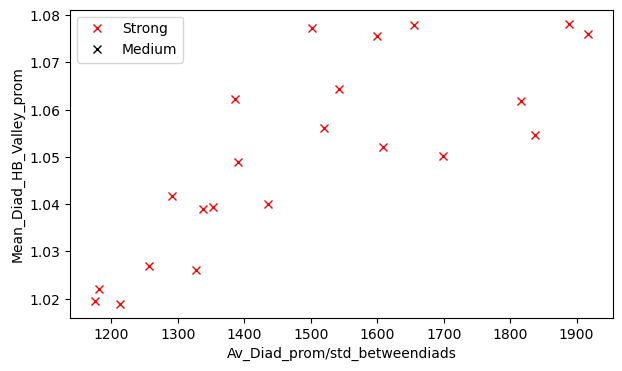

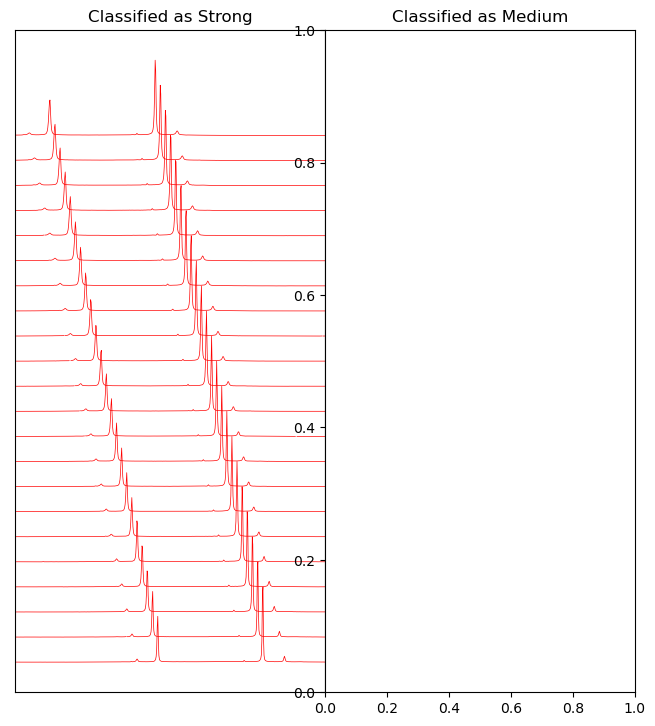

In [30]:
var1='Av_Diad_prom/std_betweendiads'
var2='Mean_Diad_HB_Valley_prom'
filter_bool_Strong=(fit_params_NotWeak[var2]>1.01)|(fit_params_NotWeak[var1]>1000)

# ((fit_params_NotWeak[var1]>100)
                   # &(fit_params_NotWeak[var2]>100))
# Here we make a plot of these parameters to better help select the right values
fig, (ax1) = plt.subplots(1, 1, figsize=(7,4))
ax1.plot(fit_params_NotWeak[var1].loc[filter_bool_Strong],
         fit_params_NotWeak[var2].loc[filter_bool_Strong], 'xr', label='Strong')
ax1.plot(fit_params_NotWeak[var1].loc[~filter_bool_Strong],
         fit_params_NotWeak[var2].loc[~filter_bool_Strong], 'xk', label='Medium')
#ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel(var1)
ax1.set_ylabel(var2)
ax1.legend()

#This makes a plot
fit_params_Strong, fit_params_Medium, data_y_Strong, data_y_Medium=pf.identify_diad_group(
    fit_params=fit_params_NotWeak.reset_index(drop=True),
    data_y=data_y_NotWeak,x_cord=Diad[:, 0],
    filter_bool=filter_bool_Strong, y_fig_scale=0.3, grp_filter='Medium-Strong')



## Plot them all 

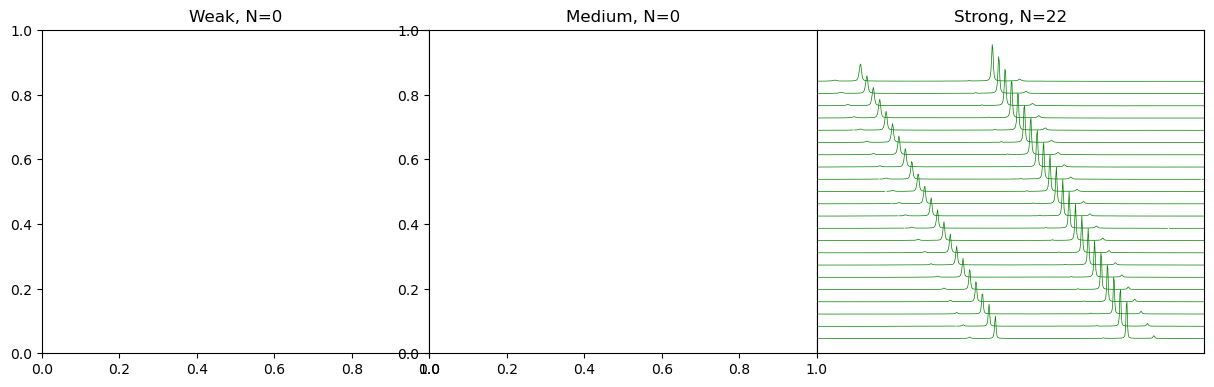

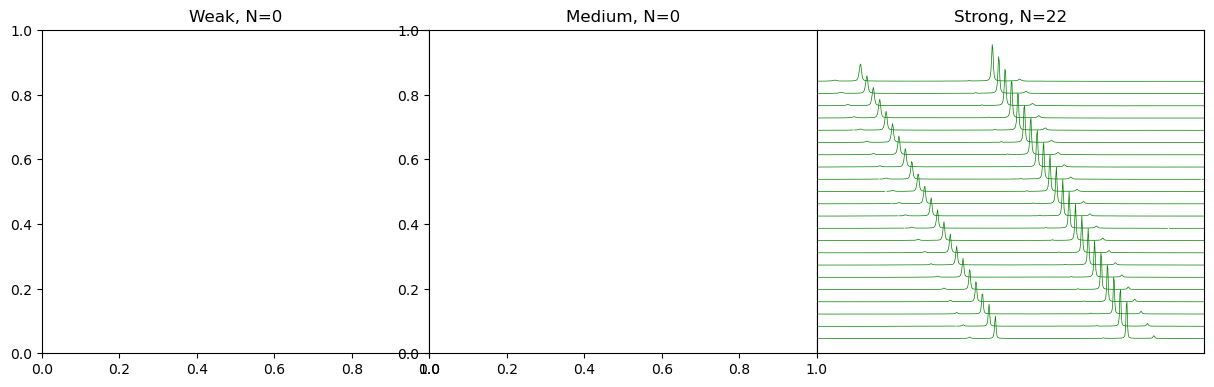

In [31]:
pf.plot_diad_groups(x_cord=Diad[:, 0], Weak_np=data_y_Weak,
                 Medium_np=data_y_Medium, Strong_np=data_y_Strong,
                   y_fig_scale=0.1)

## Now lets save these lists, and we load them in another notebook

In [32]:
import joblib
joblib.dump(Diad[:, 0], group_path+'/'+'np_x.sav')
joblib.dump(fit_params_Weak.reset_index(drop=True), group_path+'/'+'Weak_df.sav')
joblib.dump(fit_params_Medium.reset_index(drop=True), group_path+'/'+'Medium_df.sav')
joblib.dump(fit_params_Strong.reset_index(drop=True), group_path+'/'+'Strong_df.sav')
fit_params_disc.to_excel(group_path+'/'+'Discarded_df.xlsx')
